# Polynomial Regression Notebook
### Author: Krzysztof Chmielewski

# Polynomial Features Regression — Purpose and Applications

## Model Purpose

**Polynomial Regression** extends linear regression by allowing **non-linear relationships** between features and target. It transforms input features into polynomial terms (e.g., $x^2$, $x^3$) while still using linear regression on the expanded feature space.

### Key Use Cases:
- **Growth modeling**: Predicting biological growth (S-curves, exponential trends)
- **Physics simulations**: Modeling trajectories, forces, and acceleration
- **Economic analysis**: Capturing diminishing returns and non-linear effects
- **Disease progression**: Modeling disease spread with polynomial curves
- **Energy consumption**: Predicting power usage with non-linear temperature relationships
- **Manufacturing quality**: Modeling product quality degradation over time

### Strengths:
- Captures non-linear patterns while remaining interpretable
- Relatively simple to implement and understand
- Can fit complex curves without deep learning
- Hyperparameter tuning (polynomial degree) is straightforward

### Limitations:
- Risk of **overfitting** with high polynomial degrees
- Computationally more expensive than linear regression
- Extrapolation beyond training data becomes unreliable
- May require careful cross-validation to select optimal degree

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

In [163]:
def print_gs_results(gscv: GridSearchCV, param_grid: dict) -> None:
    print("\n==================== GRID SEARCH RESULTS ====================")
    print("Testowane stopnie:", param_grid["poly__degree"])
    print(f"Najlepszy stopień: {gscv.best_params_['poly__degree']}")
    print(f"Najlepszy wynik (MSE): {-gscv.best_score_:.6f}")

    print("\nWyniki dla wszystkich stopni:")
    for degree, score in zip(param_grid["poly__degree"], gscv.cv_results_["mean_test_score"]):
        print(f"  degree={degree}: MSE={-score:.6f}")

In [164]:
def print_all_folds(gscv: GridSearchCV, degrees: int) -> None:
    print("\n==================== ALL CV FOLDS ====================")

    for i, degree in enumerate(degrees):
        print(f"\n--- Degree {degree} ---")

        # znajdź indeks parametru degree=i
        idx = np.where(gscv.cv_results_["param_poly__degree"] == degree)[0][0]

        # drukuj każdy fold
        k = gscv.cv  # liczba foldów
        for fold in range(k):
            score = gscv.cv_results_[f"split{fold}_test_score"][idx]
            print(f"Fold {fold}: MSE = {-score:.6f}")

        mean_score = -gscv.cv_results_["mean_test_score"][idx]
        print(f"Średnie MSE: {mean_score:.6f}")

In [188]:
def visualize_poly_features(
        X_raw: np.ndarray,
        y_raw: np.ndarray,
        degree: int = 3,
        print_folds: bool = False,
        print_gs: bool = False,
        print_models: bool = False
    ) -> None:

    X = X_raw.reshape(-1, 1)
    y = y_raw

    pipeline = Pipeline([
        ("poly", PolynomialFeatures(include_bias=True)),
        ("linear", LinearRegression())
    ])

    param_grid = {"poly__degree": list(range(1, degree+1))}

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring = 'neg_mean_squared_error',
        cv = 5
    )

    gs.fit(X,y)

    if print_folds: print_all_folds(gs, param_grid["poly__degree"])
    if print_gs: print_gs_results(gs, param_grid)

    X_plot = np.linspace(min(X_raw), max(X_raw), 300).reshape(-1, 1)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_raw, y_raw, color="black", label="Dane", s=40)

    if print_models: print("\n==================== MODELS PER DEGREE =======================")
    for degree in param_grid["poly__degree"]:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=True)),
            ("linear", LinearRegression())
        ])

        pipe.fit(X, y)
        y_plot = pipe.predict(X_plot)
        
        if print_models:
            print(f"\n--- Stopień {degree} ---")
            print("Nazwy cech:", pipe.named_steps["poly"].get_feature_names_out(["x"]))
            print("Współczynniki:", pipe.named_steps["linear"].coef_)
            print("Bias:", pipe.named_steps["linear"].intercept_)

        plt.plot(X_plot, y_plot, alpha=0.5, label=f"degree={degree}")

    best_degree = gs.best_params_["poly__degree"]
    best_model = gs.best_estimator_
    best_y_plot = best_model.predict(X_plot)

    plt.plot(
        X_plot,
        best_y_plot,
        linewidth=3,
        label=f"Best degree = {best_degree}",
        color="red"
    )

    plt.title("Polynomial Regression - GridSearchCV")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()


==================== GRID SEARCH RESULTS ====================
Testowane stopnie: [1, 2, 3, 4, 5]
Najlepszy stopień: 2
Najlepszy wynik (MSE): 19.496406

Wyniki dla wszystkich stopni:
  degree=1: MSE=21.991138
  degree=2: MSE=19.496406
  degree=3: MSE=50.477647
  degree=4: MSE=98.761416
  degree=5: MSE=8713.769572


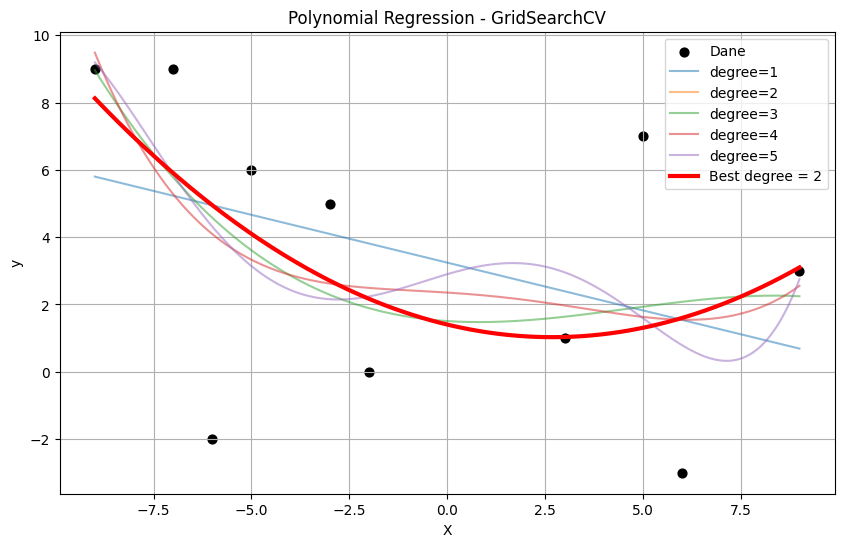

In [ ]:
X = np.random.randint(-10,10,(10,))
y = np.random.randint(-10,10,(10,))
visualize_poly_features(X, y, degree=5, print_gs=True)